In [30]:
import pandas as pd 
import numpy as np 
import os 
import matplotlib.pyplot as plt

# Objectif : prédire le nombre de bornes de recharges dans le futur

In [31]:
URL_DATASET = 'https://data.enedis.fr/api/explore/v2.1/catalog/datasets/nombre-total-de-points-de-charge/exports/csv?lang=fr&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B'
df = pd.read_csv(URL_DATASET, sep = ';')
df.sample(5)

,Trimestre,Ouvert au public,Particulier,Société
1,2022 T3,71630,623836,446585
34,2015 T3,10928,32278,38681
21,2023 T2,101681,838695,600186
18,2017 T1,17423,62957,63757
23,2022 T1,57732,515435,392504


In [4]:
df.shape

(35, 4)

In [32]:
def transform_col1(row):
    year = row.split(' ')[0]
    return year

def transform_col2(row):
    sem = row.split('T')[1]
    return sem


df['Semestre'] = df['Trimestre'].apply(transform_col2)

df['Année'] = df['Trimestre'].apply(transform_col1)
df.head()

,Trimestre,Ouvert au public,Particulier,Société,Semestre,Année
0,2023 T3,109856,906942,652131,3,2023
1,2022 T3,71630,623836,446585,3,2022
2,2020 T1,31081,172822,167797,1,2020
3,2016 T4,16220,57039,59408,4,2016
4,2020 T4,34686,267371,237863,4,2020


In [24]:
list(df.columns)

['Trimestre', 'Ouvert au public', 'Particulier', 'Société', 'Semestre']

In [33]:
df.sort_values(by = ['Année', 'Semestre'], inplace = True)
df.head()

,Trimestre,Ouvert au public,Particulier,Société,Semestre,Année
20,2015 T1,8478,25638,34746,1,2015
10,2015 T2,10086,29662,37933,2,2015
34,2015 T3,10928,32278,38681,3,2015
9,2015 T4,11113,37448,42891,4,2015
26,2016 T1,12830,43284,48013,1,2016


In [34]:
def total(dataframe):
    dataframe['Total'] = dataframe['Ouvert au public'] + dataframe['Particulier'] + dataframe['Société']
    return dataframe

df = total(df)
df.head()

,Trimestre,Ouvert au public,Particulier,Société,Semestre,Année,Total
20,2015 T1,8478,25638,34746,1,2015,68862
10,2015 T2,10086,29662,37933,2,2015,77681
34,2015 T3,10928,32278,38681,3,2015,81887
9,2015 T4,11113,37448,42891,4,2015,91452
26,2016 T1,12830,43284,48013,1,2016,104127


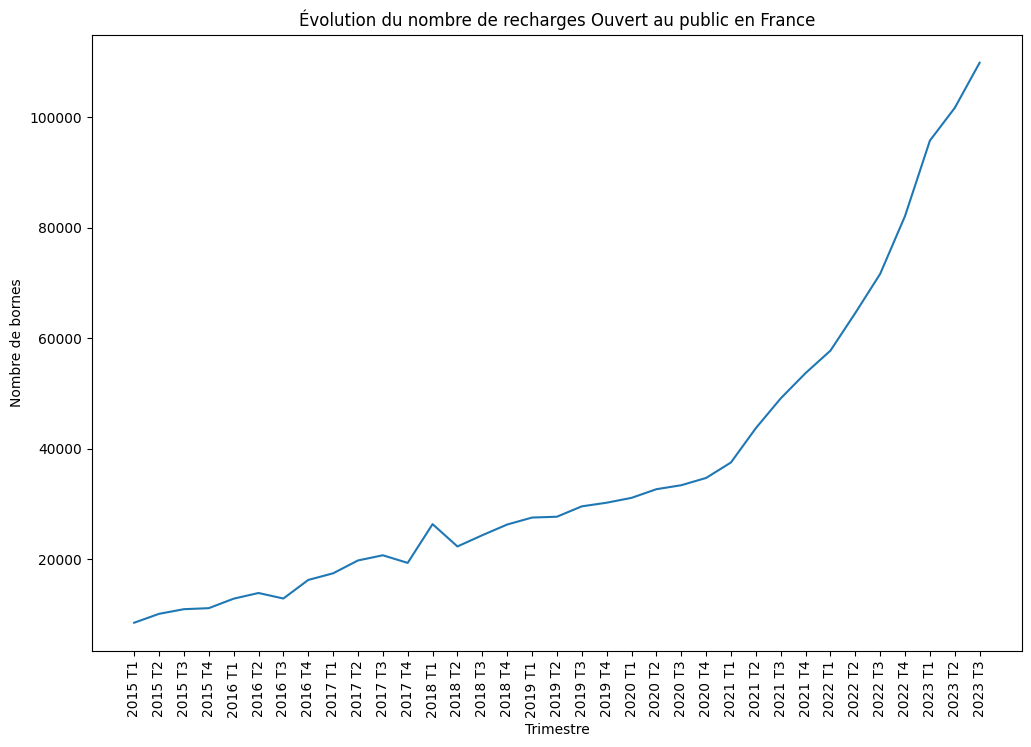

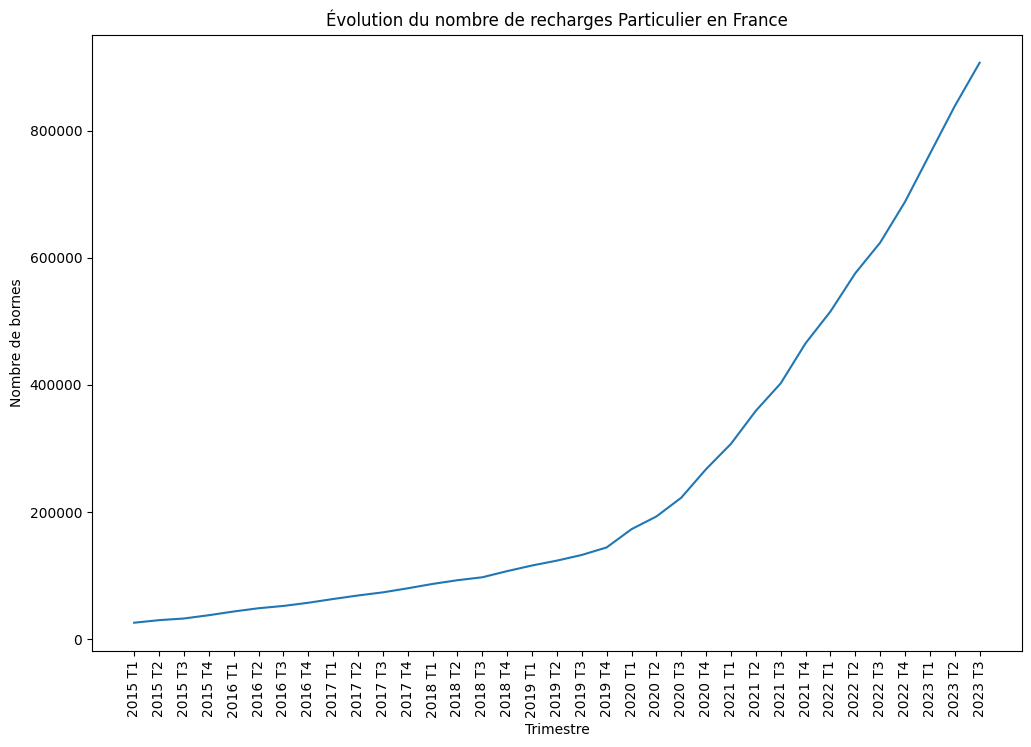

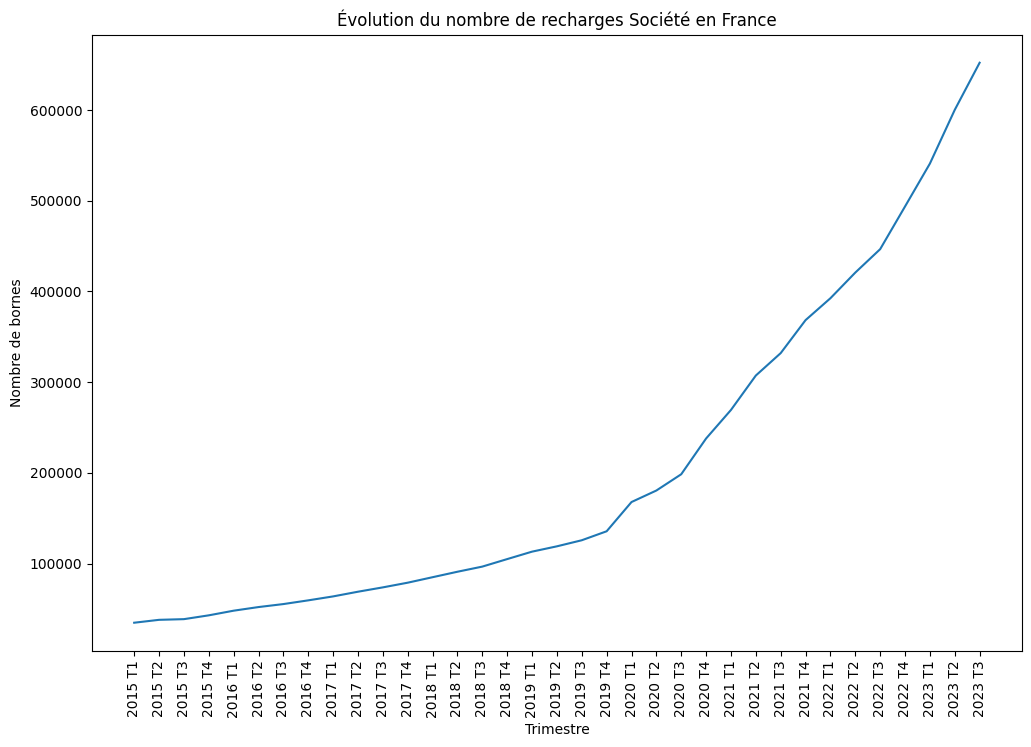

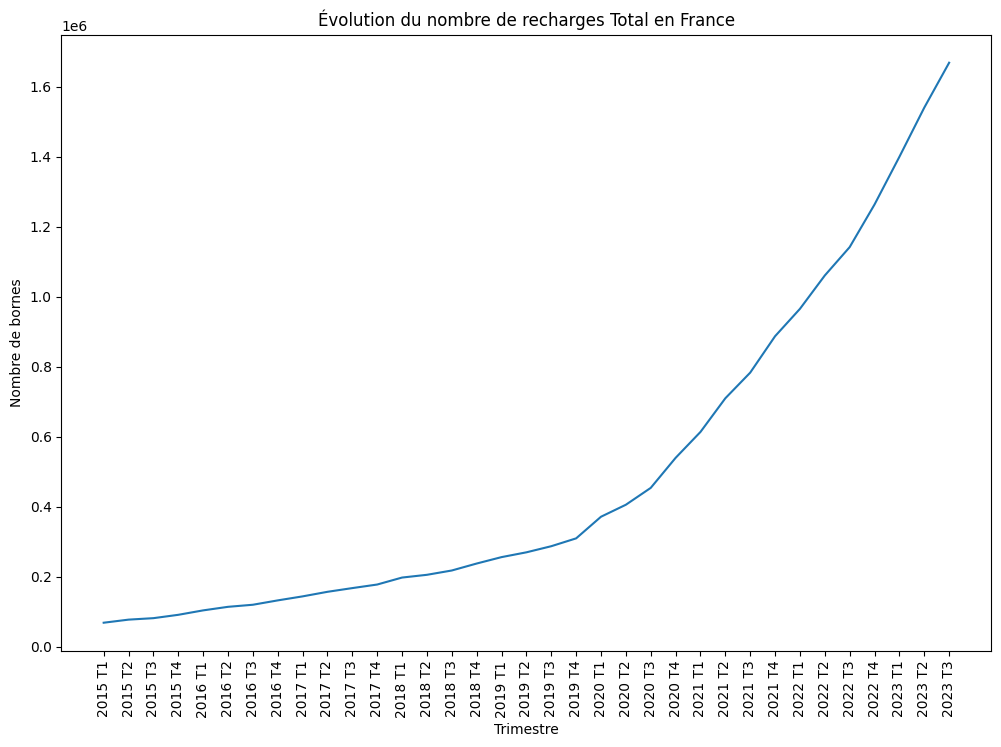

In [39]:
for col in ['Ouvert au public', 'Particulier', 'Société', 'Total']:
    plt.figure(figsize = (12,8))
    plt.plot(df['Trimestre'], df[col])
    plt.xlabel('Trimestre')
    plt.xticks(rotation=90)
    plt.ylabel('Nombre de bornes')
    plt.title(f'Évolution du nombre de recharges {col} en France')
    plt.show()